In [1]:
import numpy as np

#from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

import pandas as pd

In [2]:

# Load the Boston Housing Data
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
data.shape

(506, 13)

In [4]:

# Set the number of training, calibration, and validation points
n_calib = 200
n_valid = 20 #less data is taken for a better apperance of plot
n_train = len(target) - n_calib - n_valid

In [5]:
# Split Dataset into train, calib, and validation sets
X_train, X_calib_and_valid, y_train, y_calib_and_valid = \
    train_test_split(data, target, train_size=n_train, random_state=1)

X_calib, X_valid, y_calib, y_valid = train_test_split(X_calib_and_valid, \
    y_calib_and_valid, train_size=n_calib, random_state=1)

In [6]:
# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make Point Predictions
y_point_pred = model.predict(X_valid)

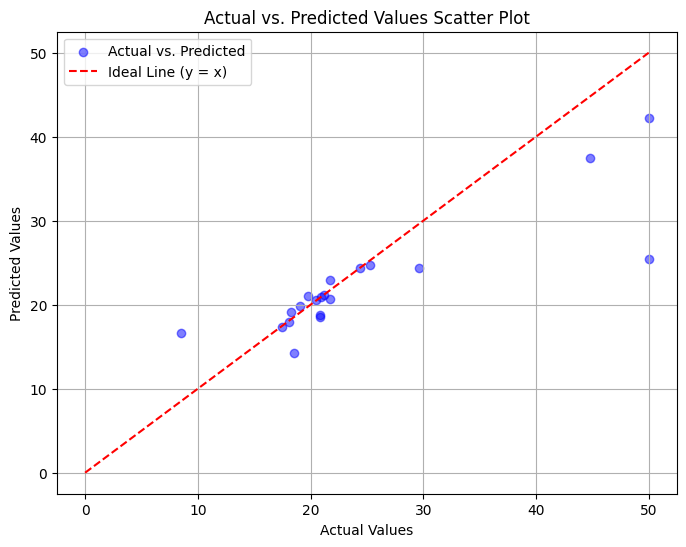

<Figure size 640x480 with 0 Axes>

In [7]:

plt.figure(figsize=(8, 6))  # Set the figure size (adjust as needed)

plt.scatter(y_valid, y_point_pred, color='blue', alpha=0.5, label='Actual vs. Predicted')
# Create a diagonal reference line
plt.plot([0, 50], [0, 50], color='red', linestyle='--', label='Ideal Line (y = x)')

# Add labels and a legend
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Scatter Plot')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines for better visualization
plt.show()
plt.savefig('PointPredictions')

## Conformalize the Point Predictor

In [8]:
delta = 0.7
quantile = np.ceil(delta*(n_calib+1))/n_calib ## to round up and then divide

In [9]:
quantile, delta, delta+1/(n_calib+1)

(0.705, 0.7, 0.7049751243781094)

In [10]:
lower_bound, upper_bound, my_upper_bound = delta, (delta+1/n_calib), (np.ceil((n_calib+1)*delta))/(n_calib+1)

In [11]:
X_calib_and_valid.shape

(220, 13)

In [12]:
class conformalizer():
    def __init__(self,
                pre_trained_model,
                delta, X_calib, y_calib, calib_metric="mae"):
        self.point_predictor = pre_trained_model
        #self.non_conformity_func = non_conformity_func
        self.n_calib = X_calib.shape[0]
        self.delta = delta
        self.X_calib, self.y_calib = X_calib, y_calib
        self.metric = calib_metric
        
        self._calibrate()
        
    def _calculate_qunatile(self, scores_calib, delta):
        # Calculate the quantile value based on delta and non-conformity scores
        self.which_quantile = np.ceil((self.delta)*(self.n_calib+1))/n_calib
        return np.quantile(scores_calib, self.which_quantile, method = "lower")
    
    def _non_conformity_func(self):
        mae =np.abs(self.y_calib_pred - self.y_calib)
        smape = 2*mae/(np.abs(self.y_calib_pred)+np.abs(self.y_calib))
        mape = mae/self.y_calib
        return np.stack((smape, mape, mae), axis=1)

    def _calibrate(self):
         # Calibrate the conformalizer to calculate q_hat
        self.y_calib_pred = self.point_predictor.predict(self.X_calib)
        scores_calib = self._non_conformity_func()
        if self.metric == "smape":
            middle_qhat = self._calculate_qunatile(scores_calib[:, 0], self.delta)
            index = np.where(scores_calib[:, 0]==middle_qhat)
            self.q_hat = scores_calib[index, 2][0]
        elif self.metric == "mape":
            middle_qhat = self._calculate_qunatile(scores_calib[:, 1], self.delta)
            index = np.where(scores_calib[:, 1]==middle_qhat)
            self.q_hat = scores_calib[index, 2][0]
        else:
            self.q_hat = self._calculate_qunatile(scores_calib[:, 2], self.delta)
        
        
        
    def predict(self, X):
        y_pred = self.point_predictor.predict(X)
        y_lower, y_upper = y_pred - self.q_hat, y_pred + self.q_hat 
        return y_lower, y_pred, y_upper
        

In [13]:
conformalized_mae = conformalizer(model, 0.9, X_calib,y_calib)
conformalized_mape = conformalizer(model, 0.9, X_calib,y_calib,calib_metric="mape")
conformalized_smape = conformalizer(model, 0.9, X_calib,y_calib,calib_metric="smape")

In [14]:
mae_lower, y_pred, mae_upper = conformalized_mae.predict(X_valid)
mape_lower, y_pred, mape_upper = conformalized_mape.predict(X_valid)
smape_lower, y_pred, smape_upper = conformalized_smape.predict(X_valid)

In [15]:
mae_lower, mape_lower, smape_lower

(array([35.04352661, 13.75830991, 13.97538127, 15.65989205, 11.89748852,
        17.49503296, 10.08312263, 12.59935898, 10.69590057, 11.30538015,
         9.43264511, 13.29836939, 13.68016259, 11.5407522 , 17.13405088,
         6.96464127, 30.2916239 , 13.42148651, 17.17810904, 18.20288394]),
 array([34.45125363, 13.16603693, 13.38310829, 15.06761907, 11.30521554,
        16.90275998,  9.49084965, 12.007086  , 10.10362759, 10.71310717,
         8.84037213, 12.70609641, 13.08788961, 10.94847922, 16.5417779 ,
         6.37236829, 29.69935092, 12.82921353, 16.58583606, 17.61061096]),
 array([36.22552266, 14.94030596, 15.15737732, 16.8418881 , 13.07948457,
        18.67702901, 11.26511868, 13.78135503, 11.87789663, 12.48737621,
        10.61464116, 14.48036544, 14.86215865, 12.72274825, 18.31604694,
         8.14663732, 31.47361995, 14.60348256, 18.36010509, 19.38487999]))

In [16]:
conformalized_mae.q_hat, conformalized_mape.q_hat, conformalized_smape.q_hat

(7.233607138724789, array([7.82588012]), array([6.05161109]))

In [17]:
fraction_within_bounds_mae = np.mean((y_valid >= mae_lower) & (y_valid <= mae_upper))
fraction_within_bounds_mape = np.mean((y_valid >= mape_lower) & (y_valid <= mape_upper))
fraction_within_bounds_smape = np.mean((y_valid >= smape_lower) & (y_valid <= smape_upper))

In [18]:
fraction_within_bounds_mae, fraction_within_bounds_mape, fraction_within_bounds_smape

(0.8, 0.9, 0.8)

In [19]:
prediction_intervals = pd.DataFrame({"mae_lower":mae_lower,"mape_lower":mape_lower,"smape_lower":mape_lower, 
                                     "actual_values":y_valid,"point_prediction":y_pred,"mae_upper":mae_upper,
                                     "mape_upper":mape_upper,"smape_upper":smape_upper})

In [20]:
round(prediction_intervals.head(10), 1)

,mae_lower,mape_lower,smape_lower,actual_values,point_prediction,mae_upper,mape_upper,smape_upper
0,35.0,34.5,34.5,50.0,42.3,49.5,50.1,48.3
1,13.8,13.2,13.2,19.8,21.0,28.2,28.8,27.0
2,14.0,13.4,13.4,21.2,21.2,28.4,29.0,27.3
3,15.7,15.1,15.1,21.7,22.9,30.1,30.7,28.9
4,11.9,11.3,11.3,18.3,19.1,26.4,27.0,25.2
5,17.5,16.9,16.9,25.3,24.7,32.0,32.6,30.8
6,10.1,9.5,9.5,17.5,17.3,24.6,25.1,23.4
7,12.6,12.0,12.0,19.1,19.8,27.1,27.7,25.9
8,10.7,10.1,10.1,18.1,17.9,25.2,25.8,24.0
9,11.3,10.7,10.7,20.8,18.5,25.8,26.4,24.6


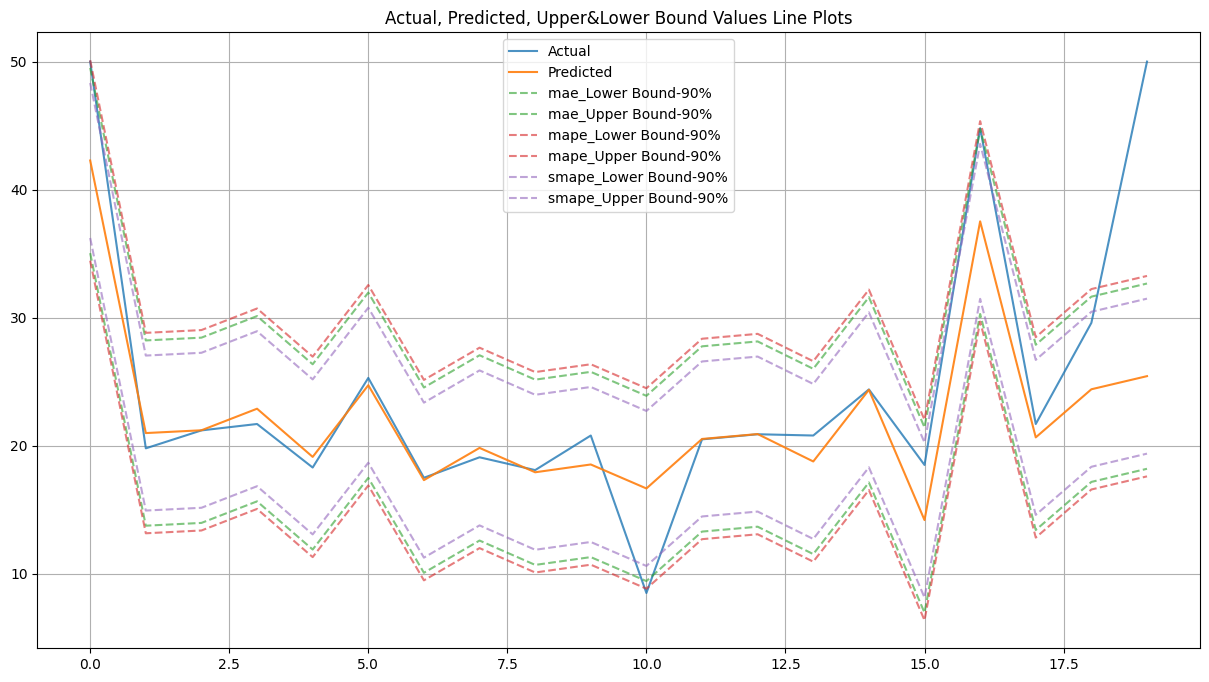

In [21]:
plt.figure(figsize=(15, 8)) 
plt.plot(y_valid, color='C0', alpha=0.8, label='Actual')
plt.plot(y_pred, color='C1', alpha=0.9, label='Predicted')
plt.plot(mae_lower, color='C2', alpha=0.6, label='mae_Lower Bound-90%', linestyle='--')
plt.plot(mae_upper, color='C2', alpha=0.6, label='mae_Upper Bound-90%', linestyle='--')

plt.plot(mape_lower, color='C3', alpha=0.6, label='mape_Lower Bound-90%', linestyle='--')
plt.plot(mape_upper, color='C3', alpha=0.6, label='mape_Upper Bound-90%', linestyle='--')

plt.plot(smape_lower, color='C4', alpha=0.6, label='smape_Lower Bound-90%', linestyle='--')
plt.plot(smape_upper, color='C4', alpha=0.6, label='smape_Upper Bound-90%', linestyle='--')

plt.legend()
plt.title('Actual, Predicted, Upper&Lower Bound Values Line Plots')
plt.grid(True)
plt.show()


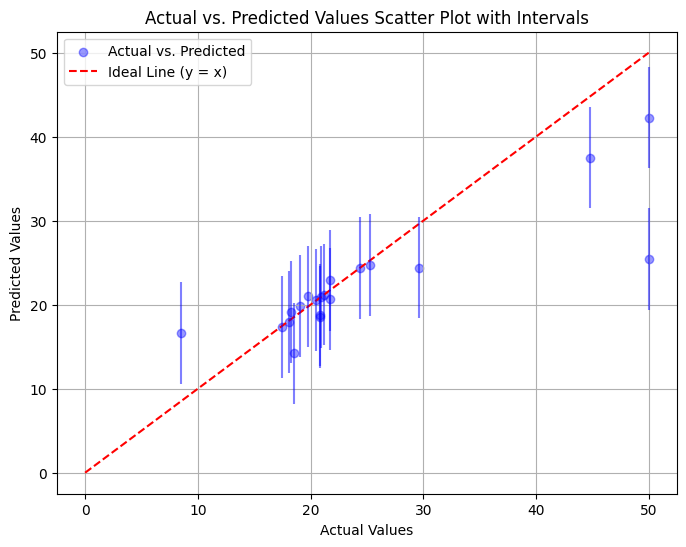

In [23]:
num_test_points_for_plot = n_valid

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size (adjust as needed)
plt.scatter(y_valid[:num_test_points_for_plot], y_pred[:num_test_points_for_plot], color='blue', alpha=0.4, label='Actual vs. Predicted')

# Create a diagonal reference line
plt.plot([0, 50], [0, 50], color='red', linestyle='--', label='Ideal Line (y = x)')

# Add error bars
interval_width = smape_upper[0] - smape_lower[0]
for i in range(num_test_points_for_plot):
    plt.errorbar(y_valid[i], y_pred[i], yerr=0.5 * (smape_upper[i] - smape_lower[i]), color='blue', alpha=0.5)

# Add labels and a legend
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Scatter Plot with Intervals')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines for better visualization
plt.show()
